# Combined Models

Here you will learn how to combine models together into a larger, more complete, model of a given system. This is a powerful and necessary capability when analysing objects in crowded environments. As telescopes achieve ever deeper photometry we have learned that all environments are crowded when projected onto the sky!

In [1]:
import autoprof as ap
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import iqr

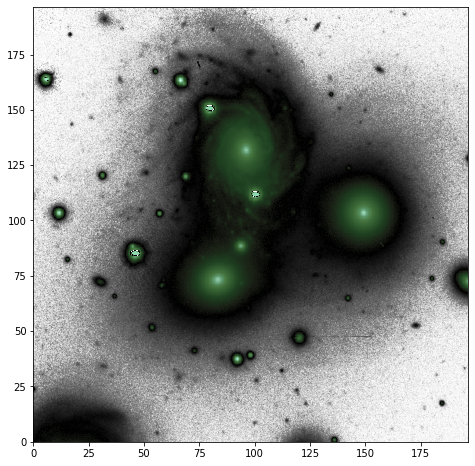

In [2]:
# first let's download an image to play with
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=4.5934&dec=30.0702&size=750&layer=ls-dr9&pixscale=0.262&bands=r")
target_data = np.array(hdu[0].data, dtype = np.float64)

target1 = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262,
    zeropoint = 22.5,
)

fig1, ax1 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig1, ax1, target1)
plt.show()

/home/connor/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


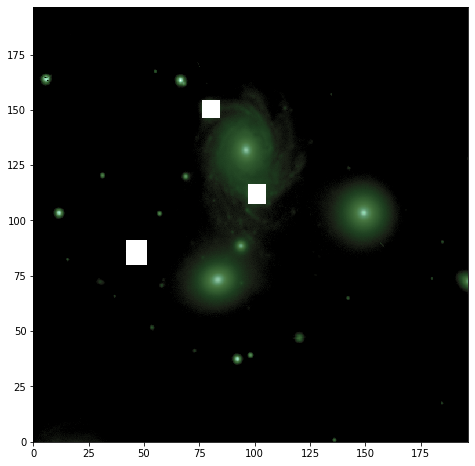

In [3]:
# We can see that there are some blown out stars in the image. There isn't much that can be done with them except
# to mask them. A very careful modeller would only mask the blown out pixels and then try to fit the rest, but
# today we are not very careful modellers.
mask = np.zeros(target_data.shape, dtype = bool)
mask[410:445,371:402] = True
mask[306:347 ,161:196] = True
mask[558:590,291:322] = True

target2 = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262,
    zeropoint = 22.5,
    mask = mask, # now the target image has a mask of bad pixels
    variance = 0.1*np.abs(target_data + iqr(target_data,rng=[16,84])), # we create a variance image, if the image is in counts then variance image = image, in this case the sky has been subtracted so we add back in a certain amount of variance
)

fig2, ax2 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig2, ax2, target2)
plt.show()

## Group Model

A group model takes a list of other AutoProf_Model objects and tracks them such that they can be treated as a single larger model. When "initialize" is called on the group model, it simply calls "initialize" on all the individual models. The same is true for a number of other functions like startup, finalize, step, sample, and so on. For fitting, however, the group model will collect the parameters from all the models together and pass them along as one group to the optimizer. When saving a group model, all the model states will be collected together into one large file. 

The main difference when constructing a group model is that you must first create all the sub models that will go in it. Once constructed, a group model behaves just like any other model, in fact they are all built from the same base class. 

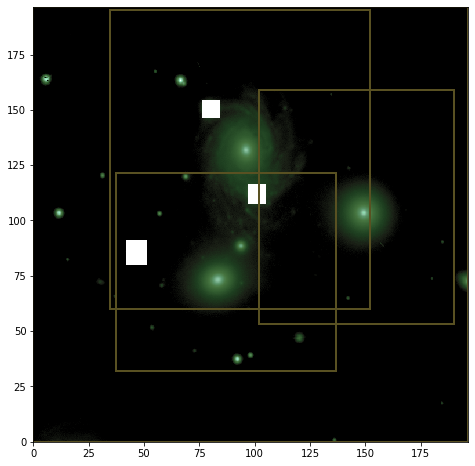

In [4]:
# first we make the list of models to fit

model_kwargs = [
    {"name": "sky", "model_type": "flat sky model", "target": target2},
    {"name": "NGC0070", "model_type": "nonparametric galaxy model", "window": [[133,581], [229,744]], "target": target2},
    {"name": "NGC0071", "model_type": "nonparametric galaxy model", "window": [[143,522], [122,463]], "target": target2},
    {"name": "NGC0068", "model_type": "nonparametric galaxy model", "window": [[390,726], [204,607]], "target": target2},
]

model_list = []
for M in model_kwargs:
    model_list.append(ap.models.AutoProf_Model(**M))
    
VV166Group = ap.models.AutoProf_Model(name = "VV166 Group", model_type = "groupmodel", model_list = model_list, target = target2)
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.model_window(fig3, ax3, VV166Group)
plt.show()

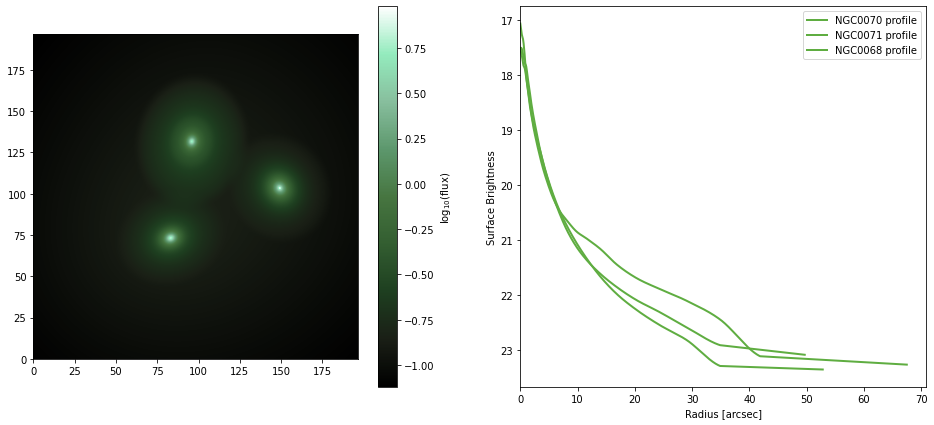

In [5]:
# See if AutoProf can figure out starting parameters for these galaxies
VV166Group.initialize()

# The results are reasonable starting points, though not yet a good model
fig4, ax4 = plt.subplots(1,2,figsize = (16,7))
ap.plots.model_image(fig4, ax4[0], VV166Group)
for M in VV166Group.model_list[1:]:
    ap.plots.galaxy_light_profile(fig4, ax4[1], M)
plt.legend()
plt.show()

In [6]:
# Allow AutoProf to fit the target image with all models simultaneously
VV166Group.fit()

Epoch: 0/256.
Epoch: 25/256.
Est time to completion: 0.85 min
Epoch: 50/256.
Est time to completion: 0.74 min
Epoch: 75/256.
Est time to completion: 0.64 min
Epoch: 100/256.
Est time to completion: 0.54 min
Epoch: 125/256.
Est time to completion: 0.45 min
Epoch: 150/256.
Est time to completion: 0.36 min
Epoch: 175/256.
Est time to completion: 0.28 min
Epoch: 200/256.
Est time to completion: 0.19 min
Epoch: 225/256.
Est time to completion: 0.11 min
Epoch: 250/256.
Est time to completion: 0.02 min
Runtime: 0.87 min
X^2/ndf: 9.522e+00


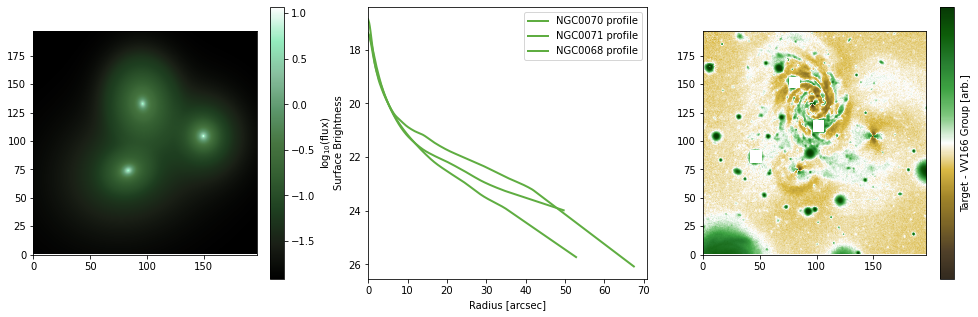

In [7]:
# Now we can see what the fitting has produced
fig5, ax5 = plt.subplots(1,3,figsize = (17,5))
ap.plots.model_image(fig5, ax5[0], VV166Group)
for M in VV166Group.model_list[1:]:
    ap.plots.galaxy_light_profile(fig5, ax5[1], M)
ax5[1].legend()
ap.plots.residual_image(fig5, ax5[2], VV166Group)
plt.show()

In [8]:
# The model will improve the more galaxies in the system we include
# By adding models now, we keep the fitted parameters from before.
VV166Group.add_model(ap.models.AutoProf_Model(name = "litte 1", model_type = "sersic galaxy model", target = target2, window = [[325,400],[295,386]]))
VV166Group.add_model(ap.models.AutoProf_Model(name = "litte 2", model_type = "sersic galaxy model", target = target2, window = [[412,504],[127,231]]))
VV166Group.add_model(ap.models.AutoProf_Model(name = "litte 3", model_type = "sersic galaxy model", target = target2, window = [[214,288],[583,662]]))

/home/connor/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


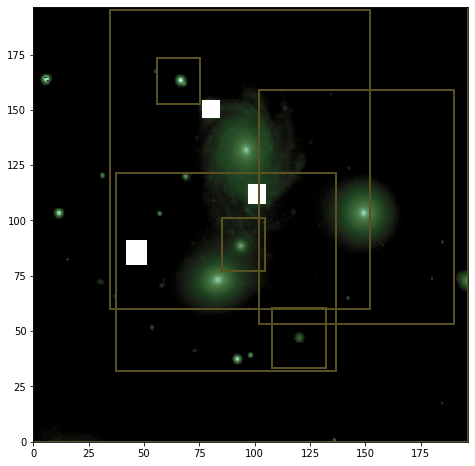

In [9]:
fig6, ax6 = plt.subplots(figsize = (8,8))
ap.plots.model_window(fig6, ax6, VV166Group)
plt.show()

In [10]:
# Initialize will only set parameter values for the new models, the old ones will just be skipped
VV166Group.initialize()

In [11]:
VV166Group.fit()

Epoch: 0/256.
Epoch: 25/256.
Est time to completion: 0.99 min
Epoch: 50/256.
Est time to completion: 0.84 min
Epoch: 75/256.
Est time to completion: 0.74 min
Epoch: 100/256.
Est time to completion: 0.64 min
Epoch: 125/256.
Est time to completion: 0.53 min
Epoch: 150/256.
Est time to completion: 0.43 min
Epoch: 175/256.
Est time to completion: 0.32 min
Epoch: 200/256.
Est time to completion: 0.22 min
Epoch: 225/256.
Est time to completion: 0.12 min
Epoch: 250/256.
Est time to completion: 0.02 min
Runtime: 1.01 min
X^2/ndf: 6.745e+00


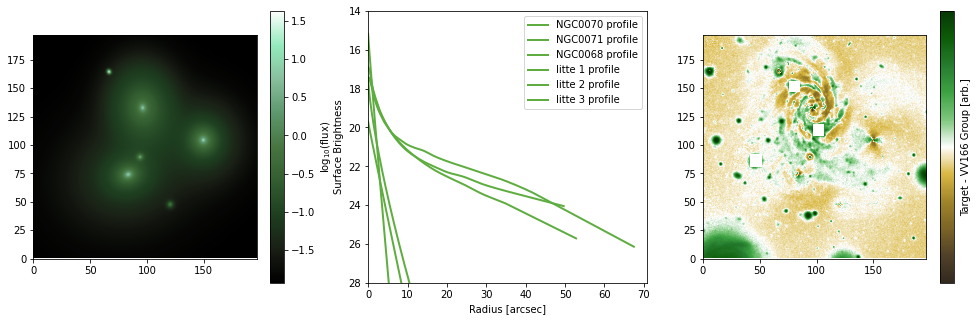

In [12]:
# Now we can see what the fitting has produced
fig7, ax7 = plt.subplots(1,3,figsize = (17,5))
ap.plots.model_image(fig7, ax7[0], VV166Group)
for M in VV166Group.model_list[1:]:
    ap.plots.galaxy_light_profile(fig7, ax7[1], M)
ax7[1].legend()
ax7[1].set_ylim([28,14])
ap.plots.residual_image(fig7, ax7[2], VV166Group)
plt.show()

Which is even better than before. As more models are added, the fit should improve. In principle one could model eventually add models for every little smudge in the image. In practice, it is often better to just mask anything below a certain size. 

## Working with segmentation maps

A segmentation map provides information about the contents of an image. It gives the location and shape of any object which the algorithm was able to separate out and identify. This is exactly the information needed to construct the windows for a collection of AutoProf models.

Photutils provides an easy to use segmentation map implimentation so we use it here for simplicity. In many cases it may be required to use a more detailed segmentation map algorithm such as those implimented in Source Extractor and ProFound (among others), the principle is the same however since the end product for all of them has the same format.

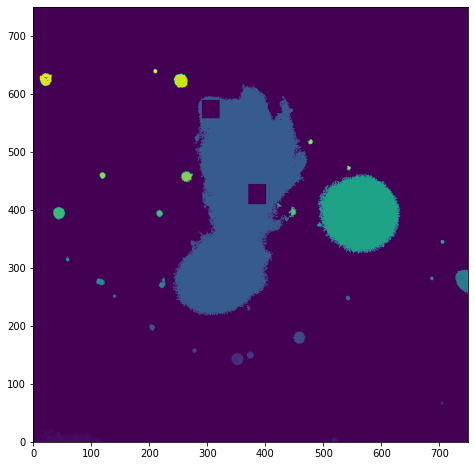

In [13]:
from photutils.segmentation import detect_sources, deblend_sources
segmap = detect_sources(target_data, threshold = 0.1, npixels = 20, mask = mask) # threshold and npixels determined just by playing around with the values
fig8, ax8 = plt.subplots(figsize=(8,8))
ax8.imshow(segmap, origin = "lower")
plt.show()

In [14]:
# This will convert the segmentation map into boxes that enclose the identified pixels
windows = ap.utils.initialize.windows_from_segmentation_map(segmap.data)
# Next we filter out any segments which are too big, these are the NGC models we already have set up
windows = ap.utils.initialize.filter_windows(windows, max_size = 100)
# Next we scale up the windows so that AutoProf can fit the faint parts of each object as well
windows = ap.utils.initialize.scale_windows(windows, image_shape = target_data.shape, expand_scale = 3, expand_border = 10)
del windows[20] # this is a segmented chunk of spiral arm, not a galaxy
del windows[23] # this is a segmented chunk of spiral arm, not a galaxy
del windows[24] # this is a segmented chunk of spiral arm, not a galaxy
print(windows)

{2: [[499, 540], [0, 24]], 3: [[689, 721], [49, 84]], 4: [[312, 392], [102, 182]], 5: [[348, 401], [123, 176]], 6: [[259, 297], [138, 176]], 7: [[417, 500], [141, 218]], 8: [[183, 227], [172, 222]], 10: [[352, 390], [209, 253]], 11: [[522, 563], [227, 268]], 12: [[124, 156], [235, 267]], 13: [[697, 750], [206, 346]], 14: [[196, 249], [238, 309]], 15: [[85, 147], [251, 301]], 16: [[671, 703], [264, 299]], 17: [[42, 77], [295, 333]], 19: [[688, 723], [327, 362]], 21: [[6, 83], [354, 434]], 22: [[193, 243], [367, 420]], 25: [[225, 305], [420, 494]], 26: [[96, 143], [434, 484]], 27: [[525, 563], [451, 492]], 28: [[456, 500], [495, 539]], 29: [[210, 299], [578, 667]], 30: [[0, 63], [583, 666]], 31: [[191, 229], [620, 658]]}


In [15]:
# Now we use all the windows to add to the list of models
for win in windows:
    model_kwargs.append({"name": f"minor object {win:02d}", "window": windows[win], "model_type": "sersic galaxy model", "target": target2})
    
# we make a new set of models for simplicity
model_list = []
for M in model_kwargs:
    model_list.append(ap.models.AutoProf_Model(**M))
VV166Group_seg = ap.models.AutoProf_Model(name = "VV166 Group seg", model_type = "groupmodel", model_list = model_list, target = target2)

# this object was between the two large galaxies, so wasn't picked up by the segmentation map, we can add it in now
VV166Group_seg.add_model(ap.models.AutoProf_Model(name = "litte 1", model_type = "sersic galaxy model", target = target2, window = [[325,400],[295,386]]))

/home/connor/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


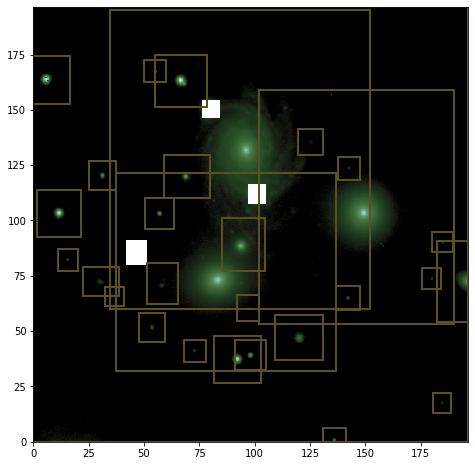

In [16]:
fig9, ax9 = plt.subplots(figsize = (8,8))
ap.plots.model_window(fig9, ax9, VV166Group_seg)
plt.show()

In [17]:
# This should only take 2-3min to fit all the models
VV166Group_seg.initialize()
VV166Group_seg.fit()

Epoch: 0/256.
Epoch: 25/256.
Est time to completion: 1.79 min
Epoch: 50/256.
Est time to completion: 1.61 min
Epoch: 75/256.
Est time to completion: 1.39 min
Epoch: 100/256.
Est time to completion: 1.18 min
Epoch: 125/256.
Est time to completion: 1.00 min
Epoch: 150/256.
Est time to completion: 0.81 min
Epoch: 175/256.
Est time to completion: 0.62 min
Epoch: 200/256.
Est time to completion: 0.44 min
Epoch: 225/256.
Est time to completion: 0.24 min
Epoch: 250/256.
Est time to completion: 0.05 min
Runtime: 2.00 min
X^2/ndf: 2.680e+00


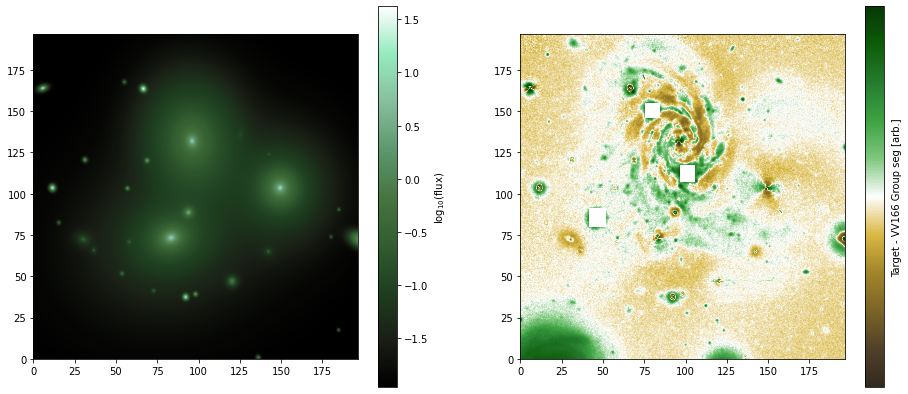

In [18]:
# Now we can see what the fitting has produced
fig10, ax10 = plt.subplots(1,2,figsize = (16,7))
ap.plots.model_image(fig10, ax10[0], VV166Group_seg)
ap.plots.residual_image(fig10, ax10[1], VV166Group_seg)
plt.show()

Now that's starting to look like a complete model, and the Chi^2/ndf is much lower! And all for very little effort considering the level of detail. Looking at the residuals there is a clear improvement from the other attempts, that said there is a lot of structure in the residuals around the small objects, suggesting that a sersic alone is not the best model for these galaxies. That's not too surprising, at the very least we should apply PSF convolution to the models to get the proper blurring. PSF convolution is very slow though, so it would be best to do on a GPU, which you can try out if you have access to one! Simply set psf_mode = "full" and run fit again. For now though, we'll forgo the PSF convolution in the interest of time.